## D(St)reams of Anomalies

### Intro: This project focuses on processing and analyzing existing data to make a anomaly detection models to determine the  anomalies  using the other columns as features.

#### This project consists of three steps
- Importing data and Droping null value
- Exploratory Data Analysis and Feature Engineering
- Use anomaly detection models to determin the anomalies

In [214]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sys 
import matplotlib 
from sklearn.ensemble import IsolationForest
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



### Importing Data and Library

In [215]:
df=pd.read_csv("../input/ambient-temperature-system-faileuescv/ambient_temperature_system_failure.csv")
df.head(10)

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279765
7,2013-07-04 07:00:00,69.369608
8,2013-07-04 08:00:00,69.166714
9,2013-07-04 09:00:00,68.986083


In [216]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

 ### Exploratory Data Analysis and Feature Engineering

In [217]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


#### Lets converting the timestamp to data format

In [219]:
df['timestamp']=pd.to_datetime(df['timestamp'])

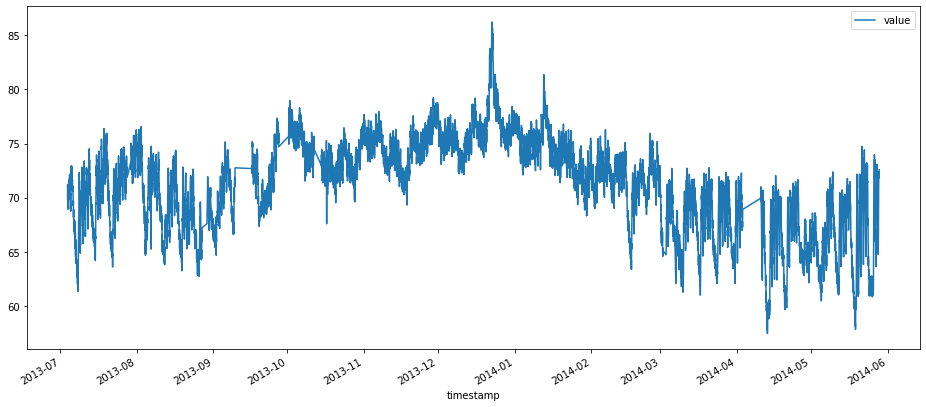

In [220]:
df.plot(x='timestamp', y='value',figsize=(16,7))

In [221]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2013-07-04 00:00:00'), Timestamp('2014-05-28 15:00:00'))

 ###  The time span of this data is less than one year, let us add some time breakdown to make the model more accurate
 ### This a dataset is about ambient temperature failue. We better consider the sperating month, day and night. 

In [222]:
df['hours'] = df['timestamp'].dt.hour
df['day&night']=((df['hours'] >= 6) & (df['hours'] <= 21)).astype(int)
df['month']=df['timestamp'].dt.month
df.head(105)

,timestamp,value,hours,day&night,month
0,2013-07-04 00:00:00,69.880835,0,0,7
1,2013-07-04 01:00:00,71.220227,1,0,7
2,2013-07-04 02:00:00,70.877805,2,0,7
3,2013-07-04 03:00:00,68.959400,3,0,7
4,2013-07-04 04:00:00,69.283551,4,0,7
...,...,...,...,...,...
100,2013-07-08 04:00:00,62.775139,4,0,7
101,2013-07-08 05:00:00,61.364476,5,0,7
102,2013-07-08 06:00:00,61.689841,6,1,7
103,2013-07-08 07:00:00,62.200489,7,1,7


### Use Isolation Forest models to determin the anomalies
reference: https://zhuanlan.zhihu.com/p/48109505


In [223]:
training_data = df[['value', 'hours', 'day&night', 'month']]


model =  IsolationForest(contamination = 0.20)
model.fit(training_data)
result = model.predict(training_data)

anomaly_points = pd.Series(result)
anomaly_points = anomaly_points.map( {1: 'nomaly', -1: "anomaly"} )
print(anomaly_points.value_counts())

nomaly     5813
anomaly    1454
dtype: int64


#### Lets try different contamination value 

In [224]:
model =  IsolationForest(contamination = 0.08)
model.fit(training_data)
result = model.predict(training_data)

anomaly_points = pd.Series(result)
anomaly_points = anomaly_points.map( {1: 'nomaly', -1: "anomaly"} )
print(anomaly_points.value_counts())

nomaly     6685
anomaly     582
dtype: int64


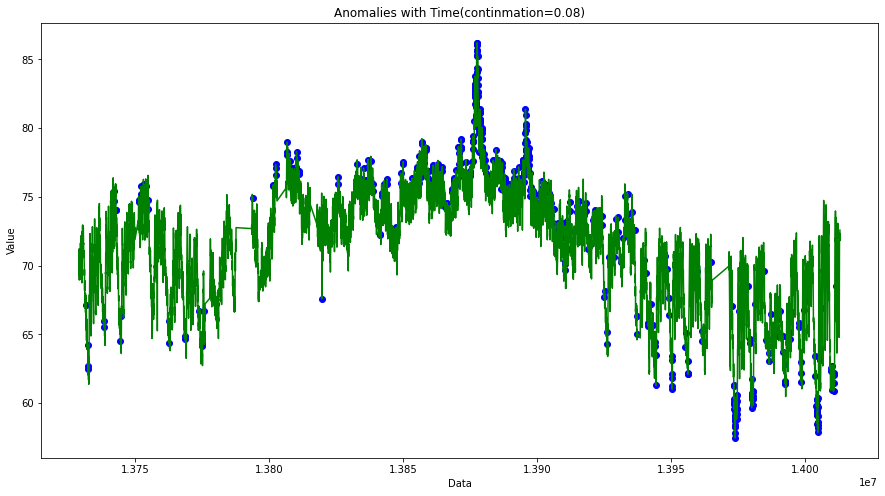

In [225]:
df['Time'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
fig, dg = plt.subplots()
a = df.loc[anomaly_points == 'anomaly', ['Time', 'value']] 
fig.set_size_inches(15,8)
dg.plot(df['Time'], df['value'], color='green')
dg.scatter(a['Time'],a['value'], color='blue')
plt.title("Anomalies with Time(continmation=0.08)")
plt.ylabel("Value")
plt.xlabel("Data")
plt.show()

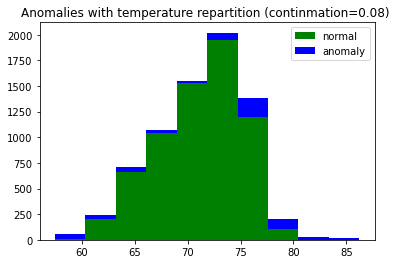

In [226]:
h= df.loc[anomaly_points == 'nomaly', 'value']
g= df.loc[anomaly_points == 'anomaly', 'value']
fig, axs = plt.subplots()
axs.hist([h,g], stacked=True, color=['green', 'blue'], label = ['normal', 'anomaly'])
plt.legend()
plt.title("Anomalies with temperature repartition (continmation=0.08) ")

plt.show()

### Conclusion
#### This is a simple data set.. So I think it is necessary to divide the date. Because the season, day and night have great important influence on temperature. I compared several popular unsupervised learning anomaly detection models, and I personally think that ioslation foreset is the most suitable one .This model has a small amount of calculation, and it is also very useful for data with low interpretability like temperature detection.However, I also found some problems in use, The choice of contamination parameters largely affects the number of final abnormal points.  The larger the contamination parameter, the greater the number of abnormal points, but I did not have an idea to choose a suitable value. For example, if the contamination =0.08, the abnormal counts = 582. if the contamination = 0.2, the abnormal counts = 1454. 

